In [1]:
import os
from pathlib import Path
from types import SimpleNamespace

cfg = SimpleNamespace(**{})
cfg.num_folds = 5
cfg.gpu = "7"
os.environ['CUDA_VISIBLE_DEVICES'] = cfg.gpu

cfg.fname = 'bird_003'
cfg.seed = 2024

cfg.input_path = Path('../input')
cfg.comp_data_path = cfg.input_path / 'birdclef-2024'
cfg.save_path = Path('../checkpoints')
cfg.soundscape_path = cfg.comp_data_path / 'unlabeled_soundscapes'

cfg.logger_file = True

# image size
cfg.image_height = 224
cfg.image_width = 224

# audio
cfg.duration = 5
cfg.sr = 32000
cfg.fmin = 90
cfg.fmax = 14000
cfg.n_fft = 1536
cfg.n_mels = cfg.image_height
cfg.win_length = 1024
cfg.hop_length = int((cfg.duration * cfg.sr - cfg.win_length + cfg.n_fft) / (cfg.image_width)) + 1 

# training HP
cfg.num_epochs = 25
cfg.train_batch_size = 128
cfg.valid_batch_size = 128
cfg.pl_batch_size = 2
cfg.pl_dup = 2
cfg.workers = 2
cfg.grad_norm = 0.0
cfg.grad_norm_type = 2
cfg.device = "cuda"
cfg.accumulate = 1

# optimizer
cfg.lr = 7e-5
cfg.decay = 0.01
cfg.opt_beta1 = 0.9
cfg.opt_beta2 = 0.999
cfg.opt_eps = 1e-8
cfg.optimizer = 'AdamW'
cfg.no_decay = False

# scheduler
cfg.pct_start = 0.1
cfg.max_lr = 3e-3
cfg.final_div_factor = 100

# augmentations
cfg.resample_train = 10
cfg.max_shift = 1
cfg.mixup_p = 0.1
cfg.db_range = 10.0

# logging
cfg.local_rank = 0
cfg.verbose=True

# model
cfg.backbone = 'efficientvit_b0.r224_in1k'
cfg.gem_pooling = False
cfg.bce = True

# tasks hp
cfg.train_model = True
cfg.num_folds = 5
cfg.pl = [cfg.save_path / cfg.fname / 'exp_201']
cfg.pretrained_path = None 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import gc
import pickle as pkl

import librosa

from torch.utils.data import DataLoader, Dataset
import torchaudio
import torchaudio.transforms as T
#import torch_audiomentations as tA

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.optim import lr_scheduler, Adam, AdamW

import timm

from glob import glob
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import roc_auc_score
from scipy.special import logit, expit

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

In [4]:
if cfg.train_model:
    checkpoint_path = cfg.save_path / cfg.fname
    if not checkpoint_path.exists():
        checkpoint_path.mkdir()
    checkpoint_path = checkpoint_path / 'exp_0'
    exp = 0
    while(checkpoint_path.exists()):
        exp += 1
        checkpoint_path = cfg.save_path / cfg.fname / ('exp_%d' % exp)
    checkpoint_path.mkdir()
    cfg.checkpoint_path = checkpoint_path
    print('saving checkpoints to', checkpoint_path)

saving checkpoints to ../checkpoints/bird_003/exp_403


In [5]:
def get_logger(cfg):
    logger = getLogger(cfg.fname)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    if cfg.logger_file and cfg.train_model:
        filename = cfg.checkpoint_path / 'run.log'
        handler2 = FileHandler(filename=filename)
        handler2.setFormatter(Formatter("%(message)s"))
        logger.addHandler(handler2)
    return logger

def seed_torch(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
    if torch.backends.cudnn.is_available:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [6]:
with open(cfg.pl[0] / f"pl_all.pkl", "rb") as file:
    pl_preds = pkl.load(file)
len(pl_preds)

8444

In [7]:
for k,pred in pl_preds.items():
    break
k, len(pred)

('../input/birdclef-2024/unlabeled_soundscapes/1000170626.ogg', 5)

In [8]:
pred[0].shape

(48, 182)

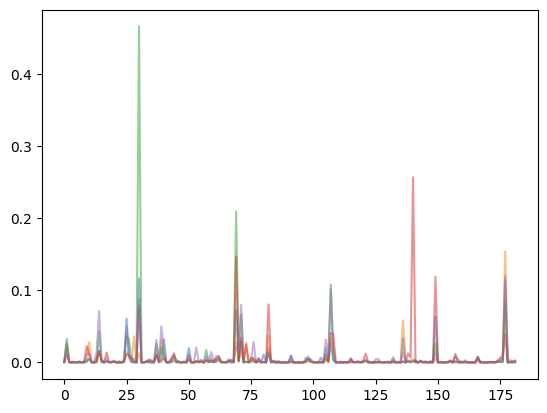

In [9]:
plt.plot(pred[0][0], alpha=0.5)
plt.plot(pred[1][0], alpha=0.5)
plt.plot(pred[2][0], alpha=0.5)
plt.plot(pred[3][0], alpha=0.5)
plt.plot(pred[4][0], alpha=0.5)

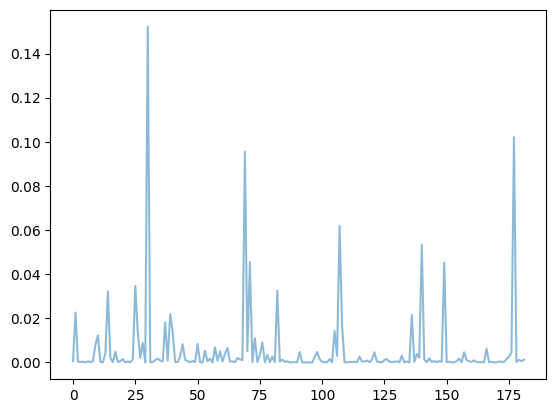

In [10]:
plt.plot(np.mean(pred, 0)[0], alpha=0.5)

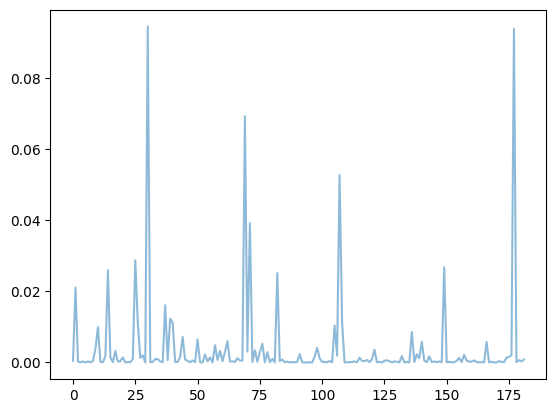

In [11]:
plt.plot(expit(np.mean(logit(np.array(pred)), 0))[0], alpha=0.5)

In [12]:
len(pl_preds)

8444

In [13]:
pl_filenames = [k for k,pred in pl_preds.items() if len(pred[0]) == 48]
len(pl_filenames)

8355

In [14]:
class BirdPLDataset():
    def __init__(self, pl_preds, fold, cfg):
        self.cfg = cfg
        pl_filenames = [k for k,pred in pl_preds.items() if len(pred[0]) == 48]
        self.filename = np.array(pl_filenames)
        self.preds = pl_preds
        self.fold = fold
        
    def __len__(self):
        return len(self.filename) * self.cfg.pl_dup
    
    def __getitem__(self, idx):
        idx = idx % len(self.filename)
        filename = self.filename[idx]
        cfg = self.cfg
        audio = librosa.load(filename, sr=cfg.sr)[0].astype(np.float32)
        duration = int(len(audio) / cfg.sr)
        periods = duration // cfg.duration
        audio = audio[:periods * cfg.duration * cfg.sr]
        audio = torch.from_numpy(audio).view(periods, -1)
        targets = self.preds[filename][self.fold].astype(np.float32)
        targets = torch.from_numpy(targets)
        secondary_mask = torch.ones(*targets.shape)
        out = {
            'audio' : audio,
            'targets' : targets,
            'secondary_mask' : secondary_mask,
        }
        return out

In [15]:
pl_dataset = BirdPLDataset(pl_preds, 2, cfg)
for k,v in pl_dataset[1].items():
    print(k, v.shape)

audio torch.Size([48, 160000])
targets torch.Size([48, 182])
secondary_mask torch.Size([48, 182])


In [16]:
def get_pl_iter(pl_preds, fold, istrain, cfg):
    pl_dataset = BirdPLDataset(pl_preds, fold, cfg)
    pl_data_loader = DataLoader(
        pl_dataset,
        batch_size=cfg.pl_batch_size,
        num_workers=0,
        shuffle=istrain,
        pin_memory=False,
        #collate_fn=collate_pad,
        drop_last = False,
    )
    
    return iter(pl_data_loader), pl_data_loader

def get_pl_batch(pl_dataloader):
    try:
        batch = next(pl_dataloader[0])
    except StopIteration:
        pl_data_loader = pl_dataloader[1]
        pl_data_loader = iter(pl_data_loader), pl_data_loader
        batch = next(pl_dataloader[0])
    new_batch = {k : v.view(v.shape[0] * v.shape[1], v.shape[2]) 
                 for k,v in batch.items()}
    return new_batch

In [17]:
pl_dataloader = get_pl_iter(pl_preds, 1, False, cfg)
batch = get_pl_batch(pl_dataloader)
for k,v in batch.items():
    print(k, v.shape)

audio torch.Size([96, 160000])
targets torch.Size([96, 182])
secondary_mask torch.Size([96, 182])


In [18]:
train = pd.read_csv(cfg.comp_data_path / 'train_metadata.csv')
train

train['species'] = [filename.split('/')[0] for filename in train.filename]
train['record'] = [filename.split('/')[1] for filename in train.filename]
train['secondary_labels'] = [eval(sls) for sls in train['secondary_labels']]

In [19]:
df = train.groupby('record').size()
df = df[df > 1]
df

record
XC163901.ogg    2
XC184466.ogg    2
XC208794.ogg    2
XC208795.ogg    2
XC209203.ogg    2
XC209549.ogg    2
XC209564.ogg    2
XC239509.ogg    2
XC306398.ogg    2
XC403621.ogg    2
XC447036.ogg    2
XC467373.ogg    2
XC503389.ogg    2
XC514027.ogg    2
XC522123.ogg    2
XC574864.ogg    2
XC581045.ogg    2
XC659329.ogg    2
XC674522.ogg    2
dtype: int64

In [20]:
df = train.groupby('record').agg({'species' : ['first', 'last'],
                                  'secondary_labels': ['first', 'last'],
                                 })
df.columns = ['first_species', 'last_species', 'first_secondary', 'last_secondary']
df = df.reset_index()
df

,record,first_species,last_species,first_secondary,last_secondary
0,XC108366.ogg,hoopoe,hoopoe,[],[]
1,XC108385.ogg,houspa,houspa,[],[]
2,XC108661.ogg,blrwar1,blrwar1,[],[]
3,XC108820.ogg,categr,categr,[],[]
4,XC108823.ogg,gloibi,gloibi,[],[]
...,...,...,...,...,...
24435,XC86990.ogg,spodov,spodov,[],[]
24436,XC86992.ogg,vefnut1,vefnut1,[],[]
24437,XC92641.ogg,stbkin1,stbkin1,[],[]
24438,XC92655.ogg,gyhcaf1,gyhcaf1,[],[]


In [21]:
train = train.merge(df[['record', 'first_species', 'last_species',]],
                   how='left',
                   on='record')

In [22]:
dups = {
    ('asbfly/XC724266.ogg', 'asbfly/XC724148.ogg'),
    ('barswa/XC575749.ogg', 'barswa/XC575747.ogg'),
    ('bcnher/XC669544.ogg', 'bcnher/XC669542.ogg'),
    ('bkskit1/XC350251.ogg', 'bkskit1/XC350249.ogg'),
    ('blhori1/XC417215.ogg', 'blhori1/XC417133.ogg'),
    ('blhori1/XC743616.ogg', 'blhori1/XC537503.ogg'),
    ('blrwar1/XC662286.ogg', 'blrwar1/XC662285.ogg'),
    ('brakit1/XC743675.ogg', 'brakit1/XC537471.ogg'),
    ('brcful1/XC197746.ogg', 'brcful1/XC157971.ogg'),
    ('brnshr/XC510751.ogg', 'brnshr/XC510750.ogg'),
    ('btbeat1/XC665307.ogg', 'btbeat1/XC513403.ogg'),
    ('btbeat1/XC743618.ogg', 'btbeat1/XC683300.ogg'),
    #('btbeat1/XC743619.ogg', 'btbeat1/XC683300.ogg'),
    ('btbeat1/XC743618.ogg', 'btbeat1/XC743619.ogg'),
    ('categr/XC787914.ogg', 'categr/XC438523.ogg'),
    ('cohcuc1/XC253418.ogg', 'cohcuc1/XC241127.ogg'),
    ('cohcuc1/XC423422.ogg', 'cohcuc1/XC423419.ogg'),
    ('comgre/XC202776.ogg', 'comgre/XC192404.ogg'),
    ('comgre/XC602468.ogg', 'comgre/XC175341.ogg'),
    ('comgre/XC64628.ogg', 'comgre/XC58586.ogg'),
    ('comior1/XC305930.ogg', 'comior1/XC303819.ogg'),
    ('comkin1/XC207123.ogg', 'comior1/XC207062.ogg'),
    ('comkin1/XC691421.ogg', 'comkin1/XC690633.ogg'),
    ('commyn/XC577887.ogg', 'commyn/XC577886.ogg'),
    ('commyn/XC652903.ogg', 'commyn/XC652901.ogg'),
    ('compea/XC665320.ogg', 'compea/XC644022.ogg'),
    ('comsan/XC385909.ogg', 'comsan/XC385908.ogg'),
    ('comsan/XC643721.ogg', 'comsan/XC642698.ogg'),
    ('comsan/XC667807.ogg', 'comsan/XC667806.ogg'),
    ('comtai1/XC126749.ogg', 'comtai1/XC122978.ogg'),
    ('comtai1/XC305210.ogg', 'comtai1/XC304811.ogg'),
    ('comtai1/XC542375.ogg', 'comtai1/XC540351.ogg'),
    ('comtai1/XC542379.ogg', 'comtai1/XC540352.ogg'),
    ('crfbar1/XC615780.ogg', 'crfbar1/XC615778.ogg'),
    ('dafbab1/XC188307.ogg', 'dafbab1/XC187059.ogg'),
    ('dafbab1/XC188308.ogg', 'dafbab1/XC187068.ogg'),
    ('dafbab1/XC188309.ogg', 'dafbab1/XC187069.ogg'),
    ('dafbab1/XC197745.ogg', 'dafbab1/XC157972.ogg'),
    ('eaywag1/XC527600.ogg', 'eaywag1/XC527598.ogg'),
    ('eucdov/XC355153.ogg', 'eucdov/XC355152.ogg'),
    ('eucdov/XC360303.ogg', 'eucdov/XC347428.ogg'),
    ('eucdov/XC365606.ogg', 'eucdov/XC124694.ogg'),
    ('eucdov/XC371039.ogg', 'eucdov/XC368596.ogg'),
    ('eucdov/XC747422.ogg', 'eucdov/XC747408.ogg'),
    ('eucdov/XC789608.ogg', 'eucdov/XC788267.ogg'),
    ('goflea1/XC163901.ogg', 'bladro1/XC163901.ogg'),
    ('goflea1/XC208794.ogg', 'bladro1/XC208794.ogg'),
    ('goflea1/XC208795.ogg', 'bladro1/XC208795.ogg'),
    ('goflea1/XC209203.ogg', 'bladro1/XC209203.ogg'),
    ('goflea1/XC209549.ogg', 'bladro1/XC209549.ogg'),
    ('goflea1/XC209564.ogg', 'bladro1/XC209564.ogg'),
    ('graher1/XC357552.ogg', 'graher1/XC357551.ogg'),
    ('graher1/XC590235.ogg', 'graher1/XC590144.ogg'),
    ('grbeat1/XC304004.ogg', 'grbeat1/XC303999.ogg'),
    ('grecou1/XC365426.ogg', 'grecou1/XC365425.ogg'),
    ('greegr/XC247286.ogg', 'categr/XC197438.ogg'),
    ('grewar3/XC743681.ogg', 'grewar3/XC537475.ogg'),
    ('grnwar1/XC197744.ogg', 'grnwar1/XC157973.ogg'),
    ('grtdro1/XC651708.ogg', 'grtdro1/XC613192.ogg'),
    ('grywag/XC459760.ogg', 'grywag/XC457124.ogg'),
    ('grywag/XC575903.ogg', 'grywag/XC575901.ogg'),
    ('grywag/XC650696.ogg', 'grywag/XC592019.ogg'),
    ('grywag/XC690448.ogg', 'grywag/XC655063.ogg'),
    ('grywag/XC745653.ogg', 'grywag/XC745650.ogg'),
    ('grywag/XC812496.ogg', 'grywag/XC812495.ogg'),
    ('heswoo1/XC357155.ogg', 'heswoo1/XC357149.ogg'),
    ('heswoo1/XC744698.ogg', 'heswoo1/XC665715.ogg'),
    ('hoopoe/XC631301.ogg', 'hoopoe/XC365530.ogg'),
    ('hoopoe/XC631304.ogg', 'hoopoe/XC252584.ogg'),
    ('houcro1/XC744704.ogg', 'houcro1/XC683047.ogg'),
    ('houspa/XC326675.ogg', 'houspa/XC326674.ogg'),
    ('inbrob1/XC744708.ogg', 'inbrob1/XC744706.ogg'),
    ('insowl1/XC305214.ogg', 'insowl1/XC301142.ogg'),
    ('junbab2/XC282587.ogg', 'junbab2/XC282586.ogg'),
    ('labcro1/XC267645.ogg', 'labcro1/XC265731.ogg'),
    ('labcro1/XC345836.ogg', 'labcro1/XC312582.ogg'),
    ('labcro1/XC37773.ogg', 'labcro1/XC19736.ogg'),
    ('labcro1/XC447036.ogg', 'houcro1/XC447036.ogg'),
    ('labcro1/XC823514.ogg', 'gybpri1/XC823527.ogg'),
    ('laudov1/XC185511.ogg', 'grewar3/XC185505.ogg'),
    ('laudov1/XC405375.ogg', 'laudov1/XC405374.ogg'),
    ('laudov1/XC514027.ogg', 'eucdov/XC514027.ogg'),
    ('lblwar1/XC197743.ogg', 'lblwar1/XC157974.ogg'),
    ('lewduc1/XC261506.ogg', 'lewduc1/XC254813.ogg'),
    ('litegr/XC403621.ogg', 'bcnher/XC403621.ogg'),
    ('litegr/XC535540.ogg', 'litegr/XC448898.ogg'),
    ('litegr/XC535552.ogg', 'litegr/XC447850.ogg'),
    ('litgre1/XC630775.ogg', 'litgre1/XC630560.ogg'),
    ('litgre1/XC776082.ogg', 'litgre1/XC663244.ogg'),
    ('litspi1/XC674522.ogg', 'comtai1/XC674522.ogg'),
    ('litspi1/XC722435.ogg', 'litspi1/XC721636.ogg'),
    ('litspi1/XC722436.ogg', 'litspi1/XC721637.ogg'),
    ('litswi1/XC443070.ogg', 'litswi1/XC440301.ogg'),
    ('lobsun2/XC197742.ogg', 'lobsun2/XC157975.ogg'),
    ('maghor2/XC197740.ogg', 'maghor2/XC157978.ogg'),
    ('maghor2/XC786588.ogg', 'maghor2/XC786587.ogg'),
    ('malpar1/XC197770.ogg', 'malpar1/XC157976.ogg'),
    ('marsan/XC383290.ogg', 'marsan/XC383288.ogg'),
    ('marsan/XC733175.ogg', 'marsan/XC716673.ogg'),
    ('mawthr1/XC455222.ogg', 'mawthr1/XC455211.ogg'),
    ('orihob2/XC557991.ogg', 'orihob2/XC557293.ogg'),
    ('piebus1/XC165050.ogg', 'piebus1/XC122395.ogg'),
    ('piebus1/XC814459.ogg', 'piebus1/XC792272.ogg'),
    ('placuc3/XC490344.ogg', 'placuc3/XC486683.ogg'),
    ('placuc3/XC572952.ogg', 'placuc3/XC572950.ogg'),
    ('plaflo1/XC615781.ogg', 'plaflo1/XC614946.ogg'),
    ('purher1/XC467373.ogg', 'graher1/XC467373.ogg'),
    ('purher1/XC827209.ogg', 'purher1/XC827207.ogg'),
    ('pursun3/XC268375.ogg', 'comtai1/XC241382.ogg'),
    ('pursun4/XC514853.ogg', 'pursun4/XC514852.ogg'),
    ('putbab1/XC574864.ogg', 'brcful1/XC574864.ogg'),
    ('rewbul/XC306398.ogg', 'bkcbul1/XC306398.ogg'),
    ('rewbul/XC713308.ogg', 'asbfly/XC713467.ogg'),
    ('rewlap1/XC733007.ogg', 'rewlap1/XC732874.ogg'),
    ('rorpar/XC199488.ogg', 'rorpar/XC199339.ogg'),
    ('rorpar/XC402325.ogg', 'comior1/XC402326.ogg'),
    ('rorpar/XC516404.ogg', 'rorpar/XC516402.ogg'),
    ('sbeowl1/XC522123.ogg', 'brfowl1/XC522123.ogg'),
    ('sohmyn1/XC744700.ogg', 'sohmyn1/XC743682.ogg'),
    ('spepic1/XC804432.ogg', 'spepic1/XC804431.ogg'),
    ('spodov/XC163930.ogg', 'bladro1/XC163901.ogg'),
    ('spodov/XC163930.ogg', 'goflea1/XC163901.ogg'),
    ('spoowl1/XC591485.ogg', 'spoowl1/XC591177.ogg'),
    ('stbkin1/XC266782.ogg', 'stbkin1/XC266682.ogg'),
    ('stbkin1/XC360661.ogg', 'stbkin1/XC199815.ogg'),
    ('stbkin1/XC406140.ogg', 'stbkin1/XC406138.ogg'),
    ('vefnut1/XC197738.ogg', 'vefnut1/XC157979.ogg'),
    ('vefnut1/XC293526.ogg', 'vefnut1/XC289785.ogg'),
    ('wemhar1/XC581045.ogg', 'comsan/XC581045.ogg'),
    ('wemhar1/XC590355.ogg', 'wemhar1/XC590354.ogg'),
    ('whbbul2/XC335671.ogg', 'whbbul2/XC335670.ogg'),
    ('whbsho3/XC856465.ogg', 'whbsho3/XC856463.ogg'),
    #('whbsho3/XC856468.ogg', 'whbsho3/XC856463.ogg'),
    ('whbsho3/XC856465.ogg', 'whbsho3/XC856468.ogg'),
    ('whbwat1/XC840073.ogg', 'whbwat1/XC840071.ogg'),
    ('whbwoo2/XC239509.ogg', 'rufwoo2/XC239509.ogg'),
    ('whcbar1/XC659329.ogg', 'insowl1/XC659329.ogg'),
    ('whiter2/XC265271.ogg', 'whiter2/XC265267.ogg'),
    ('whtkin2/XC197737.ogg', 'whtkin2/XC157981.ogg'),
    ('whtkin2/XC430267.ogg', 'whtkin2/XC430256.ogg'),
    ('whtkin2/XC503389.ogg', 'comior1/XC503389.ogg'),
    ('whtkin2/XC540094.ogg', 'whtkin2/XC540087.ogg'),
    ('woosan/XC184466.ogg', 'marsan/XC184466.ogg'),
    ('woosan/XC545316.ogg', 'woosan/XC476064.ogg'),
    ('woosan/XC587076.ogg', 'woosan/XC578599.ogg'),
    ('woosan/XC742927.ogg', 'woosan/XC740798.ogg'),
    ('woosan/XC825766.ogg', 'grnsan/XC825765.ogg'),
    ('zitcis1/XC303866.ogg', 'zitcis1/XC302781.ogg'),
}

In [23]:
def to_remove(r0, r1):
    name0 = r0.split('/')[0]
    name1 = r1.split('/')[0]
    return name0 == name1

In [24]:
dups = [(r0,r1) for (r0,r1) in dups if to_remove(r0, r1)]
len(dups)

117

In [25]:
to_remove = set(r1 for r0,r1 in dups)
len(to_remove)

117

In [26]:
train = train[~train.filename.isin(to_remove)].reset_index(drop=True)

In [27]:
train = train.groupby('record').first().reset_index()

In [28]:
train

,record,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,species,first_species,last_species
0,XC108366.ogg,hoopoe,[],['song'],48.532000,17.231000,Upupa epops,Eurasian Hoopoe,Alexander Kurthy,Creative Commons Attribution-ShareAlike 4.0,3.5,https://www.xeno-canto.org/108366,hoopoe/XC108366.ogg,hoopoe,hoopoe,hoopoe
1,XC108385.ogg,houspa,[],['song'],48.040000,17.496000,Passer domesticus,House Sparrow,Alexander Kurthy,Creative Commons Attribution-ShareAlike 4.0,3.5,https://www.xeno-canto.org/108385,houspa/XC108385.ogg,houspa,houspa,houspa
2,XC108661.ogg,blrwar1,[],['song'],58.318024,13.835984,Acrocephalus dumetorum,Blyth's Reed Warbler,Patrik Åberg,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/108661,blrwar1/XC108661.ogg,blrwar1,blrwar1,blrwar1
3,XC108820.ogg,categr,[],['call'],28.899000,-81.808000,Bubulcus ibis,Cattle Egret,Andrew Spencer,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/108820,categr/XC108820.ogg,categr,categr,categr
4,XC108823.ogg,gloibi,[],"['begging call', 'call']",28.899000,-81.808000,Plegadis falcinellus,Glossy Ibis,Andrew Spencer,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/108823,gloibi/XC108823.ogg,gloibi,gloibi,gloibi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24318,XC86990.ogg,spodov,[],['song'],NaN,NaN,Streptopelia chinensis,Spotted Dove,David Edwards,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/86990,spodov/XC86990.ogg,spodov,spodov,spodov
24319,XC86992.ogg,vefnut1,[],['song'],NaN,NaN,Sitta frontalis,Velvet-fronted Nuthatch,David Edwards,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/86992,vefnut1/XC86992.ogg,vefnut1,vefnut1,vefnut1
24320,XC92641.ogg,stbkin1,[],['song'],12.165541,106.690979,Pelargopsis capensis,Stork-billed Kingfisher,David Edwards,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/92641,stbkin1/XC92641.ogg,stbkin1,stbkin1,stbkin1
24321,XC92655.ogg,gyhcaf1,[],['song'],NaN,NaN,Culicicapa ceylonensis,Gray-headed Canary-Flycatcher,David Edwards,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/92655,gyhcaf1/XC92655.ogg,gyhcaf1,gyhcaf1,gyhcaf1


In [29]:
def load_audio(filename, first, istrain, cfg):
    filepath = filename.split('/')[0]
    fname = filename.split('/')[1].split('.')[0]
    filepath = cfg.input_path / 'birdclef_data' / filepath 
    if istrain:
        max_duration =  int((cfg.duration + cfg.max_shift) * cfg.sr)
    else:
        max_duration = cfg.duration * cfg.sr
    if first:
        filepath = filepath / f"first10_{fname}.npy"
        audio = np.load(filepath)
        audio = audio[:max_duration]
    else:
        filepath = filepath / f"last10_{fname}.npy"
        audio = np.load(filepath)
        audio = audio[-max_duration:]
    return audio

In [30]:
load_audio('asbfly/XC134896.ogg', True, True, cfg).shape

(192000,)

In [31]:
new_train = []

kf = KFold(n_splits=cfg.num_folds, shuffle=True, random_state=0)
for species, df in train.groupby('species'):
    df = df.reset_index(drop=True)
    df['fold'] = -1
    for fold, (train_index, valid_index) in enumerate(kf.split(df, df.primary_label)):
        df.loc[valid_index, "fold"] = int(fold)
    new_train.append(df)
new_train = pd.concat(new_train).reset_index(drop=True)    
new_train.fold.value_counts()

0    4932
1    4897
2    4866
3    4838
4    4790
Name: fold, dtype: int64

In [32]:
new_train.groupby(['species', 'fold']).size().unstack()

fold,0,1,2,3,4
species,,,,,
asbfly,21,21,21,21,20
ashdro1,22,22,22,22,21
ashpri1,20,19,19,19,19
ashwoo2,9,9,9,9,9
asikoe2,55,55,55,55,55
...,...,...,...,...,...
woosan,100,99,99,99,99
wynlau1,2,1,1,1,1
yebbab1,6,6,6,5,5


In [33]:
train = new_train

In [34]:
train

,record,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,species,first_species,last_species,fold
0,XC134896.ogg,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg,asbfly,asbfly,asbfly,2
1,XC164848.ogg,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg,asbfly,asbfly,asbfly,2
2,XC175797.ogg,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg,asbfly,asbfly,asbfly,0
3,XC207738.ogg,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg,asbfly,asbfly,asbfly,1
4,XC209218.ogg,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg,asbfly,asbfly,asbfly,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24318,XC845747.ogg,zitcis1,[],[''],43.5925,4.5434,Cisticola juncidis,Zitting Cisticola,Chèvremont Fabian,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://xeno-canto.org/845747,zitcis1/XC845747.ogg,zitcis1,zitcis1,zitcis1,3
24319,XC845817.ogg,zitcis1,[],[''],43.5925,4.5434,Cisticola juncidis,Zitting Cisticola,Chèvremont Fabian,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/845817,zitcis1/XC845817.ogg,zitcis1,zitcis1,zitcis1,1
24320,XC856176.ogg,zitcis1,[],[''],51.1207,4.5607,Cisticola juncidis,Zitting Cisticola,Wim Jacobs,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/856176,zitcis1/XC856176.ogg,zitcis1,zitcis1,zitcis1,3
24321,XC856723.ogg,zitcis1,[],[''],41.5607,-8.4236,Cisticola juncidis,Zitting Cisticola,Jorge Leitão,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://xeno-canto.org/856723,zitcis1/XC856723.ogg,zitcis1,zitcis1,zitcis1,4


In [35]:
def metric(preds, targets, cfg):
    score = {}
    for j,label in enumerate(cfg.labels):
        score[label] = roc_auc_score(targets[:, j], preds[:, j])
    score_avg = np.mean([v for k,v in score.items()])
    return score_avg, score

def metric_db(train, oofs, cfg):
    score = {}
    for j,label in enumerate(cfg.labels):
        score[label] = roc_auc_score(train.primary_label == label, oofs[label])
    score_avg = np.mean([v for k,v in score.items()])
    return score_avg, score
    
def my_softmax(preds):
    preds = preds - preds.max(1, keepdims=True)
    preds = np.exp(preds.clip(-20, 0))
    preds = preds / preds.sum(1, keepdims=True)
    return preds

def bce_with_mask(preds, targets, mask):
    loss = nn.BCEWithLogitsLoss(reduction='none')(preds, targets)
    loss = loss * mask
    loss = loss.mean()
    return loss
    

In [36]:
cfg.device = torch.device('cuda')
if cfg.bce:
    #cfg.loss = nn.BCEWithLogitsLoss()
    cfg.loss = bce_with_mask
else:
    cfg.loss = nn.CrossEntropyLoss()

cfg.labels = np.array(sorted(train.species.unique()))
cfg.num_labels = len(cfg.labels)
cfg.targets = {v : i for i,v in enumerate(cfg.labels)}

cfg.logger = get_logger(cfg)
seed_torch(cfg.seed)

In [37]:
class BirdDataset():
    def __init__(self, train, istrain, cfg):
        self.cfg = cfg
        self.istrain = istrain
        self.filename = train.filename.values
        #self.primary_label = train.primary_label.values
        self.secondary_labels = train.secondary_labels.values
        self.first_species = train.first_species.values
        self.last_species = train.last_species.values
        
    def __len__(self):
        return len(self.filename)
    
    def get_audio(self, idx):
        filename = self.filename[idx]
        duration = self.cfg.sr * self.cfg.duration
        if self.istrain:
            first = np.random.rand() < 0.5
            audio = load_audio(filename, first, True, self.cfg)
            if len(audio) < duration:
                pad_length = np.random.randint(0, duration - len(audio) + 1) 
                audio = np.pad(audio, 
                               ((pad_length, duration - len(audio) - pad_length),), 
                               mode='constant')
            else:
                start = np.random.randint(0, len(audio) - duration + 1)
                audio = audio[start : start + duration]
        else:
            audio = load_audio(filename, True, False, self.cfg)
            audio = audio[:duration]
            if len(audio) < duration:
                pad_length = (duration - len(audio)) // 2
                audio = np.pad(audio, 
                               ((pad_length, duration - len(audio) - pad_length),), 
                               mode='constant')
        return audio
      
    def __getitem__(self, idx):
        audio = self.get_audio(idx)
        targets = np.zeros(len(cfg.labels), dtype=np.float32)        
        targets[self.cfg.targets[self.first_species[idx]]] = 1.0
        targets[self.cfg.targets[self.last_species[idx]]] = 1.0
        secondary_mask = np.ones(len(cfg.labels), dtype=np.float32)
        secondary_labels = self.secondary_labels[idx]
        if len(secondary_labels) > 0:
            for label in secondary_labels:
                if label in cfg.targets:
                    secondary_mask[cfg.targets[label]] = 0
        secondary_mask = np.maximum(secondary_mask, targets)        
        out = {
            'audio' : torch.from_numpy(audio),
            'targets' : torch.from_numpy(targets),
            'secondary_mask' : secondary_mask,
        }
        return out

def batch_to_device(batch, device):
    return {k:batch[k].to(device, non_blocking=True) for k in batch.keys() if k not in []}

In [38]:
dataset = BirdDataset(train, True, cfg)
elt = dataset[0]
for k,v in elt.items():
    print(k, v.shape)

audio torch.Size([160000])
targets torch.Size([182])
secondary_mask (182,)


In [39]:
def get_data_loader(dataset, istrain, cfg):
    if istrain:
        batch_size = cfg.train_batch_size
    else:
        batch_size = cfg.valid_batch_size
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=cfg.workers,
        shuffle=istrain,
        pin_memory=False,
        #collate_fn=collate_pad,
        drop_last = istrain,
    )
    return data_loader 

In [40]:
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6, p_trainable=True):
        super(GeM,self).__init__()
        if p_trainable:
            self.p = Parameter(torch.ones(1)*p)
        else:
            self.p = p
        self.eps = eps

    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

class BirdModel(nn.Module):
    def __init__(self, cfg, pretrained: bool = True):
        super(BirdModel, self).__init__()
        self.cfg = cfg
        self.mel = T.MelSpectrogram(
            sample_rate=cfg.sr, n_fft=cfg.n_fft, win_length=cfg.win_length, 
            hop_length= cfg.hop_length, f_min=cfg.fmin, f_max=cfg.fmax, 
            n_mels=cfg.n_mels, mel_scale='htk', power=2.0)
        self.A2DB = T.AmplitudeToDB(stype="power")
        self.backbone = timm.create_model(
            cfg.backbone,
            pretrained=pretrained,
            drop_rate = 0.1,
            #drop_path_rate = 0.2,
            num_classes=cfg.num_labels, 
            #global_pool=''
        )
        #if cfg.gem_pooling == "gem":
        #    self.backbone.head.global_pool = GeM(p_trainable=args.p_trainable)
         
    def forward(self, input_dict):
        x = input_dict['audio']
        with autocast(enabled=False), torch.no_grad():
            x = x / torch.std(x, 1, keepdim=True)
            x = x.float()
            x = self.mel(x)
            x = self.A2DB(x)
            x = (x - 40) / 80
        with torch.no_grad():
            x = x.unsqueeze(1)
            pos = torch.linspace(0., 1., x.size(2)).to(x.device)
            pos = pos.unsqueeze(0).unsqueeze(0).unsqueeze(-1)
            pos = pos.expand(x.size(0), 1, x.size(2), x.size(3))
            x = x.expand(-1, 2, -1, -1)
            x = torch.cat([x, pos], 1)

        x = self.backbone(x)
        return x

In [41]:
data_loader = get_data_loader(dataset, False, cfg)
model = BirdModel(cfg)
for batch in data_loader:
    break
out = model(batch)
out.shape

torch.Size([128, 182])

In [42]:
def train_epoch(loader, pl_data_loader, model, optimizer, scheduler, scaler, device, cfg):
    model.train()
    model.zero_grad()
    if cfg.verbose:
        bar = tqdm(range(len(loader)))
    else:
        bar = range(len(loader))
    load_iter = iter(loader)
    loss_l = []
    grad_norm_l = []
    
    accumulate = cfg.accumulate
    
    for i, batch in zip(bar, load_iter):
        input_dict0 = batch_to_device(batch, device)
        pl_batch = get_pl_batch(pl_data_loader)
        pl_dict = batch_to_device(pl_batch, device)
        input_dict = {
            k : torch.cat([input_dict0[k], pl_dict[k]], 0) for k in input_dict0.keys()
        }
        with autocast(enabled=True):
            targets = input_dict['targets']
            secondary_mask = input_dict['secondary_mask']
            mixup = (np.random.rand() < cfg.mixup_p)
            if mixup:
                bs = targets.shape[0]
                perm = torch.randperm(bs).to(targets.device)
                weight = 0.1 ** (cfg.db_range *  np.random.rand() / 10)
                audio = input_dict['audio']
                audio = audio + weight * audio[perm]
                input_dict['audio'] = audio
                secondary_mask = torch.minimum(secondary_mask, secondary_mask[perm])
                targets = torch.maximum(targets, targets[perm])
                secondary_mask = torch.maximum(secondary_mask, targets)        
            preds = model(input_dict)
            loss = cfg.loss(preds, targets, secondary_mask).mean()
        loss_l.append(loss.detach().cpu().item())
        scaler.scale(loss / cfg.accumulate).backward() 
        accumulate -= 1
        if accumulate == 0:
            if cfg.grad_norm:
                scaler.unscale_(optimizer)
                total_norm = nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_norm).item()
                if np.isnan(total_norm):
                    total_norm = cfg.grad_norm
                else:
                    total_norm = np.clip(total_norm, 0, cfg.grad_norm)
                grad_norm_l.append(total_norm)
            scaler.step(optimizer)     
            scaler.update()
            optimizer.zero_grad()
            accumulate = cfg.accumulate
            scheduler.step()  
        del preds, targets, loss, input_dict
        if cfg.verbose:
            if cfg.grad_norm:
                bar.set_description('loss: %.4f grad norm %.1f' % (np.mean(loss_l), np.mean(grad_norm_l),))
            else:
                bar.set_description('loss: %.4f ' % np.mean(loss_l))
    optimizer.zero_grad()
    del loss_l, bar
    gc.collect()

In [43]:
def valid_epoch(loader, model, device, cfg):
    model.eval()
    model.zero_grad()
    if cfg.verbose:
        bar = tqdm(range(len(loader)))
    else:
        bar = range(len(loader))
    load_iter = iter(loader)
    preds_l = []
    targets_l = []
    with torch.no_grad():
        for i, batch in zip(bar, load_iter):      
            input_dict = batch_to_device(batch, device)
            with autocast(enabled=False):
                preds = model(input_dict)                
            preds_l.append(preds.detach().cpu())
            del preds, input_dict
            targets = batch['targets']
            targets_l.append(targets)
        preds = torch.cat(preds_l)
        targets = torch.cat(targets_l)
        return preds.numpy(), targets.numpy()

In [44]:
def get_optimizer(model, cfg):
    no_decay = ["bias", "Norm"]
    if cfg.no_decay:
        optimizer_parameters = [
            {'params': [p for n, p in model.named_parameters() 
                        if not any(nd in n for nd in no_decay)],
             'weight_decay': cfg.decay},
            {'params': [p for n, p in model.named_parameters() 
                        if any(nd in n for nd in no_decay)],
             'weight_decay': 0.0},
        ] 
    else:
        optimizer_parameters = model.parameters()
    optimizer = torch.optim.AdamW(optimizer_parameters, lr=cfg.lr)
    return optimizer

def get_scheduler(optimizer, train_data_loader, cfg):
    scheduler = lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=cfg.max_lr,
        epochs=cfg.num_epochs,
        steps_per_epoch=len(train_data_loader),
        pct_start=cfg.pct_start,
        anneal_strategy="cos",
        final_div_factor=cfg.final_div_factor,
    )
    return scheduler

In [45]:
def save_checkpoint(model, fold, seed, cfg):
    checkpoint = {
        'model' : model.state_dict(),
        'fold' : fold,
        'seed' : seed,
        }
    checkpoint_path = cfg.checkpoint_path
    save_path = checkpoint_path / ('%s_%d_%d.pt' % (cfg.fname, fold, seed))
    if cfg.local_rank == 0:
        cfg.logger.info('saving %s ...' % save_path)
    torch.save(checkpoint, save_path)
    if cfg.local_rank == 0:
        cfg.logger.info('done')

def load_checkpoint(fold, seed, cfg):
    if cfg.pretrained_path:
        checkpoint_path = cfg.pretrained_path
    else:
        checkpoint_path = cfg.checkpoint_path
    save_path = checkpoint_path / ('%s_%d_%d.pt' % (cfg.fname, fold, seed, ))
    cfg.logger.info('loading %s ...' % save_path)
    checkpoint = torch.load(save_path, map_location='cpu')
    model = BirdModel(cfg, pretrained=False).to(cfg.device)
    model.load_state_dict(checkpoint['model'], strict=True)
    model.eval()
    cfg.logger.info('done')
    return model


In [46]:
def resample(train_fold, cfg):
    new_train = []
    for species, df in train.groupby('species'):
        new_train.append(df)
        if len(df) < cfg.resample_train:
            df = df.sample(n=(cfg.resample_train - len(df)), replace=True, random_state=cfg.seed)
            new_train.append(df)
    new_train = pd.concat(new_train).reset_index(drop=True)  
    return new_train  

In [47]:
scores = []
oofs = pd.DataFrame(columns=cfg.labels, index=train.index, data = 0.0)
oofs['filename'] = train.filename

In [48]:
for fold in range(cfg.num_folds):
    seed = cfg.seed + fold
    seed_torch(seed)
    train_fold = train[train.fold != fold]
    valid_dataset = BirdDataset(train[train.fold == fold], False, cfg)
    valid_dataloader = get_data_loader(valid_dataset, istrain=False, cfg=cfg)
    device = cfg.device
    
    if cfg.pretrained_path:
        model = load_checkpoint(fold, seed, cfg)
    else:
        model = BirdModel(cfg, pretrained=True).to(device)
    optimizer = get_optimizer(model, cfg)
    scheduler = None
    scaler = GradScaler()
    result = None
    pl_data_loader = get_pl_iter(pl_preds, fold, False, cfg)
    for epoch in range(cfg.num_epochs):
        if cfg.resample_train:
            train_fold = resample(train_fold, cfg)
        train_dataset = BirdDataset(train_fold, True, cfg)
        train_dataloader = get_data_loader(train_dataset, istrain=True, cfg=cfg)

        if scheduler is None:
            scheduler = get_scheduler(optimizer, train_dataloader, cfg)
        train_epoch(train_dataloader, pl_data_loader, model, 
                    optimizer, scheduler, scaler, device, cfg)
        if valid_dataset is not None:
            preds, targets = valid_epoch(valid_dataloader, model, device, cfg)
            if cfg.bce:
                preds = expit(preds) # model uses logits
            else:
                preds = my_softmax(preds) # model uses logits
            result, _ = metric(preds, targets, cfg)
            msg = f"seed {cfg.seed} fold {fold} epoch {epoch} metric {result:.4f}"
            cfg.logger.info(msg)
        else:
            msg = f"seed {cfg.seed} fold {fold} epoch {epoch}"
            cfg.logger.info(msg)
    if cfg.local_rank == 0:
        save_checkpoint(model, fold, seed, cfg)
    del model, optimizer, scheduler, scaler, train_dataloader, 
    if valid_dataset is not None:
        del valid_dataloader
    gc.collect()
    torch.cuda.empty_cache()
    scores.append(result)
    
    for j,c in enumerate(cfg.labels):
        oofs.loc[train.fold == fold, c] = preds[:, j]
oofs.to_csv(cfg.checkpoint_path / 'oofs.csv', index=False)

np.mean(scores), metric_db(train, oofs, cfg)

  0%|          | 0/190 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 39/39 [00:05<00:00,  6.61it/s]
seed 2024 fold 0 epoch 0 metric 0.6744
100%|██████████| 39/39 [00:05<00:00,  7.00it/s]
seed 2024 fold 0 epoch 1 metric 0.7063
100%|██████████| 39/39 [00:05<00:00,  6.81it/s]
seed 2024 fold 0 epoch 2 metric 0.7758
100%|██████████| 39/39 [00:05<00:00,  7.13it/s]
seed 2024 fold 0 epoch 3 metric 0.9471
100%|██████████| 39/39 [00:05<00:00,  7.05it/s]
seed 2024 fold 0 epoch 4 metric 0.9363
100%|██████████| 39/39 [00:05<00:00,  7.06it/s]
seed 2024 fold 0 epoch 5 metric 0.9766
100%|██████████| 39/39 [00:05<0

(0.9997637242346092,
 (0.9997191033424985,
  {'asbfly': 0.9994822882225335,
   'ashdro1': 0.9992403363586007,
   'ashpri1': 0.9999901108955573,
   'ashwoo2': 0.9999981693531409,
   'asikoe2': 0.9998193007923547,
   'asiope1': 1.0,
   'aspfly1': 0.9999651745546301,
   'aspswi1': 0.9999889191764733,
   'barfly1': 0.9999753116899148,
   'barswa': 0.9995540947576819,
   'bcnher': 0.9995733575949751,
   'bkcbul1': 0.9990860392060028,
   'bkrfla1': 0.9999162557520943,
   'bkskit1': 0.999973532419361,
   'bkwsti': 0.9997650170003778,
   'bladro1': 0.9998839573518472,
   'blaeag1': 1.0,
   'blakit1': 0.9999505862447917,
   'blhori1': 0.9997661811007694,
   'blnmon1': 0.9999138333393172,
   'blrwar1': 0.9991943255214256,
   'bncwoo3': 1.0,
   'brakit1': 0.9999798858281291,
   'brasta1': 0.9989684523621175,
   'brcful1': 0.9996825597142067,
   'brfowl1': 0.995447747106742,
   'brnhao1': 0.9997490281190115,
   'brnshr': 0.9993459054961151,
   'brodro1': 0.9997811456229487,
   'brwjac1': 0.9999999

In [49]:
res = metric_db(train, oofs, cfg)
res

(0.9997191033424985,
 {'asbfly': 0.9994822882225335,
  'ashdro1': 0.9992403363586007,
  'ashpri1': 0.9999901108955573,
  'ashwoo2': 0.9999981693531409,
  'asikoe2': 0.9998193007923547,
  'asiope1': 1.0,
  'aspfly1': 0.9999651745546301,
  'aspswi1': 0.9999889191764733,
  'barfly1': 0.9999753116899148,
  'barswa': 0.9995540947576819,
  'bcnher': 0.9995733575949751,
  'bkcbul1': 0.9990860392060028,
  'bkrfla1': 0.9999162557520943,
  'bkskit1': 0.999973532419361,
  'bkwsti': 0.9997650170003778,
  'bladro1': 0.9998839573518472,
  'blaeag1': 1.0,
  'blakit1': 0.9999505862447917,
  'blhori1': 0.9997661811007694,
  'blnmon1': 0.9999138333393172,
  'blrwar1': 0.9991943255214256,
  'bncwoo3': 1.0,
  'brakit1': 0.9999798858281291,
  'brasta1': 0.9989684523621175,
  'brcful1': 0.9996825597142067,
  'brfowl1': 0.995447747106742,
  'brnhao1': 0.9997490281190115,
  'brnshr': 0.9993459054961151,
  'brodro1': 0.9997811456229487,
  'brwjac1': 0.9999999999999999,
  'brwowl1': 0.9992126461147114,
  'btbea

In [50]:
dfe = train.groupby('primary_label').size()
dfe.name = 'size'
dfe = dfe.reset_index().sort_values('primary_label').reset_index(drop=True)
dfe

,primary_label,size
0,asbfly,104
1,ashdro1,109
2,ashpri1,96
3,ashwoo2,45
4,asikoe2,275
...,...,...
177,woosan,496
178,wynlau1,6
179,yebbab1,28
180,yebbul3,30


In [51]:
df = pd.DataFrame({'label' : cfg.labels, 
                   'roc_auc' : [res[1][label] for label in cfg.labels],
                   'size' : dfe['size'].values,
                  })
df

,label,roc_auc,size
0,asbfly,0.999482,104
1,ashdro1,0.999240,109
2,ashpri1,0.999990,96
3,ashwoo2,0.999998,45
4,asikoe2,0.999819,275
...,...,...,...
177,woosan,0.999115,496
178,wynlau1,0.999945,6
179,yebbab1,0.999996,28
180,yebbul3,0.999938,30


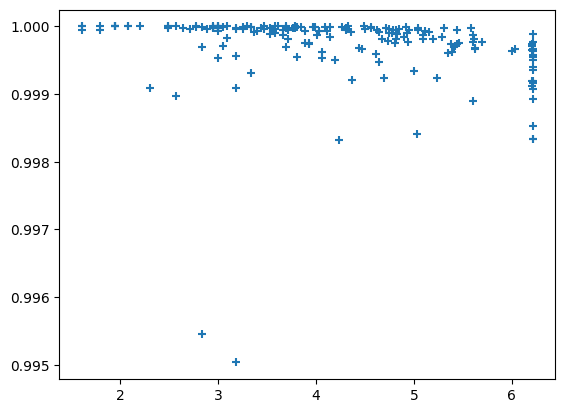

In [52]:
plt.scatter(np.log(df['size']), df['roc_auc'], marker='+')

In [53]:
df.sort_values('roc_auc')

,label,roc_auc,size
56,eurbla2,0.995034,24
25,brfowl1,0.995448,17
42,compea,0.998327,69
57,eurcoo,0.998334,500
62,graher1,0.998335,498
...,...,...,...
85,indrob1,1.000000,44
16,blaeag1,1.000000,6
148,rutfly6,1.000000,8
124,paisto1,1.000000,7


In [54]:
df = train.groupby('primary_label').size()
df = df / df.sum()
df.name = 'avg'
df = df.to_frame()
df['oof'] = oofs[cfg.labels].mean(0)
df

,avg,oof
primary_label,,
asbfly,0.004276,0.004696
ashdro1,0.004481,0.005097
ashpri1,0.003947,0.004393
ashwoo2,0.001850,0.001973
asikoe2,0.011306,0.012134
...,...,...
woosan,0.020392,0.022247
wynlau1,0.000247,0.000330
yebbab1,0.001151,0.001378


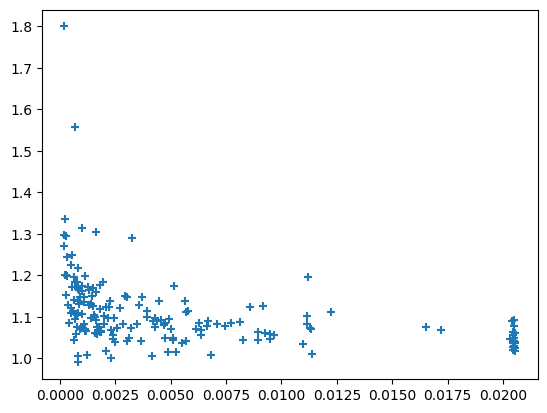

In [55]:
plt.scatter(df.avg, df.oof/df.avg, marker='+')

In [56]:
class SoundScapeDataset():
    def __init__(self, soundscape, istrain, cfg):
        self.cfg = cfg
        self.istrain = istrain
        self.soundscape = soundscape
        self.duration = int(np.round(soundscape.shape[0] / cfg.sr))
        self.starts = np.arange(0, self.duration, cfg.duration)
        self.ends = self.starts + cfg.duration
        self.starts = cfg.sr * self.starts
        self.ends = cfg.sr * self.ends
        
    def __len__(self):
        return len(self.starts)
    
    def __getitem__(self, idx):
        audio = self.soundscape[self.starts[idx] : self.ends[idx]]
        duration = self.cfg.sr * self.cfg.duration
        if len(audio) < duration:
            pad_length = (duration - len(audio)) // 2
            audio = np.pad(audio, 
                           ((pad_length, duration - len(audio) - pad_length),), 
                           mode='constant')
        out = {
            'audio' : torch.from_numpy(audio),
        }
        return out

def predict(loader, models, cfg):
    for model in models:
        model.eval()
        model.zero_grad()
    if cfg.verbose:
        bar = tqdm(range(len(loader)))
    else:
        bar = range(len(loader))
    load_iter = iter(loader)
    preds_l = [[] for model in models]
    targets_l = []
    with torch.no_grad():
        for i, batch in zip(bar, load_iter):      
            input_dict = batch_to_device(batch, cfg.device)
            with autocast(enabled=False):
                for preds, model in zip(preds_l, models):
                    preds.append(model(input_dict).detach().cpu()) 
            del input_dict
        preds_l = [torch.cat(preds).squeeze().numpy() for preds in preds_l]
        return preds_l

def load_soundscape(pathname, cfg):
    audio = librosa.load(pathname, sr=32000)[0].astype(np.float32)
    return audio

def predict_soundscape(filepath, models, cfg):
    waveform = load_soundscape(filepath, cfg)
    #return len(waveform) / cfg.sr
    #return waveform
    #print('duration',  len(waveform) / cfg.sr)
    dataset = SoundScapeDataset(waveform, False, cfg)
    dataloader = get_data_loader(dataset, False, cfg)
    preds_l = predict(dataloader, models, cfg)
    if cfg.bce:
        preds_l = [expit(preds) for preds in preds_l] # model uses logits
    else:
        preds_l = [my_softmax(preds) for preds in preds_l] # model uses logits
    return preds_l

In [57]:
soundscapes = sorted(glob(str(cfg.soundscape_path / '*.ogg')))
soundscapes[:5]



['../input/birdclef-2024/unlabeled_soundscapes/1000170626.ogg',
 '../input/birdclef-2024/unlabeled_soundscapes/1000308629.ogg',
 '../input/birdclef-2024/unlabeled_soundscapes/1000389428.ogg',
 '../input/birdclef-2024/unlabeled_soundscapes/1000424265.ogg',
 '../input/birdclef-2024/unlabeled_soundscapes/1000450112.ogg']

In [58]:
cfg.verbose = False
cfg.workers = 0
cfg.valid_batch_size = 128

models = [load_checkpoint(fold, cfg.seed + fold, cfg).to(cfg.device)
          for fold in range(cfg.num_folds)
         ]
preds = {}
for soundscape in tqdm(soundscapes):
    preds[soundscape]  = predict_soundscape(soundscape, models, cfg)
with open(cfg.checkpoint_path / f"pl_all.pkl", "wb") as file:
    pkl.dump(preds, file)

loading ../checkpoints/bird_003/exp_403/bird_003_0_2024.pt ...
done
loading ../checkpoints/bird_003/exp_403/bird_003_1_2025.pt ...
done
loading ../checkpoints/bird_003/exp_403/bird_003_2_2026.pt ...
done
loading ../checkpoints/bird_003/exp_403/bird_003_3_2027.pt ...
done
loading ../checkpoints/bird_003/exp_403/bird_003_4_2028.pt ...
done
100%|██████████| 8444/8444 [1:05:51<00:00,  2.14it/s]
